In [2]:

# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
import warnings
warnings.filterwarnings("ignore")

In [13]:
dat= pd.read_csv("cleaned.csv")
dat.dtypes

VETERAN3          float64
SEXVAR              int64
_URBSTAT          float64
lgbtq               int64
dis                 int64
_AGE_G            float64
_EDUCAG           float64
INCOME2           float64
PERSDOC2          float64
CHECKUP1          float64
LASTDEN4          float64
MEDCOST           float64
HLTHPLN1          float64
GENHLTH           float64
_SMOKER3          float64
_DRNKWK1          float64
EXERANY2          float64
_LTASTH1          float64
ADDEPEV3          float64
state              object
avgqoc            float64
married             int64
divorced            int64
widowed             int64
single              int64
coupled             int64
employed            int64
selfemployed        int64
worklessover1       int64
worklessunder1      int64
student             int64
retired             int64
unable              int64
own                 int64
rent                int64
white               int64
black               int64
aian                int64
asian       

In [64]:
dat['dis'].value_counts()

2.0    138139
3.0    119502
1.0     81660
4.0     46239
5.0     15457
Name: GENHLTH, dtype: int64

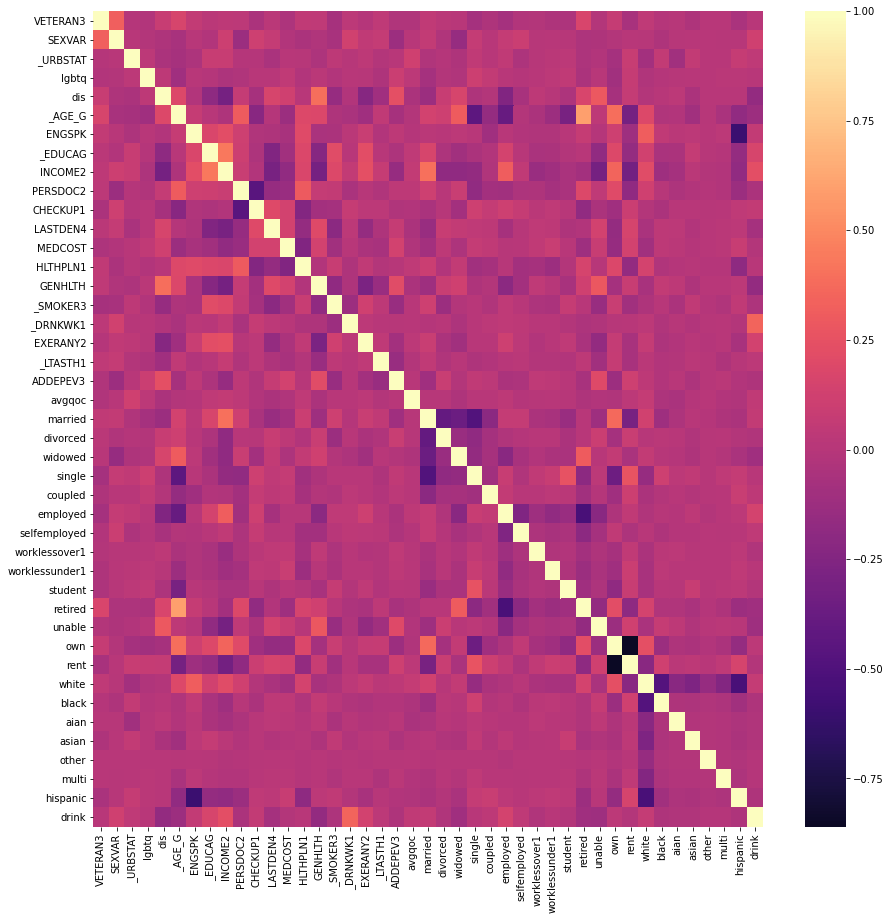

In [5]:
M = dat.select_dtypes(include=["int64", "float64"]).corr()

#plotting the float variables' correlations found above as a heat map
plt.figure(figsize = (15,15))
sns.heatmap(M, center=0,cmap="magma")
plt.show()

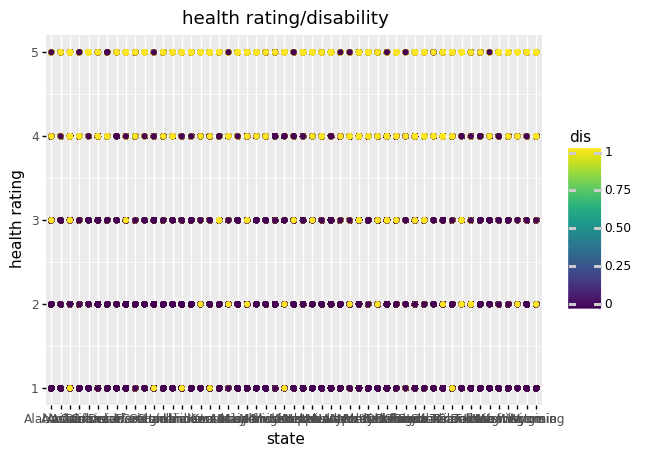

<ggplot: (126972034362)>

In [6]:
(
    ggplot(dat,aes(x = "state",y='GENHLTH', groupby ='dis')) +
    geom_point(aes(color = "dis"))
      + labs(title = "health rating/disability",
          x= "state",
          y= "health rating")
)

In [ ]:
dat.filter(['dis','GENHLTH']).groupby(['dis']).mean(['GENHLTH'])

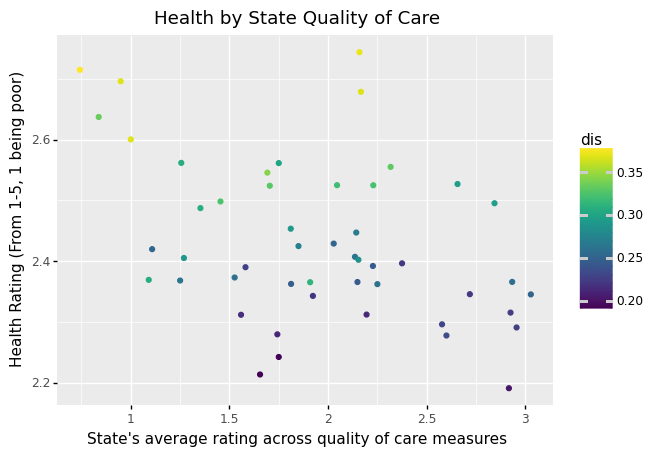

<ggplot: (126972048722)>

In [77]:
#plotting deaths and cases per 100k people
stategrp = (dat
       .groupby(["state"])
       .mean(["GENHLTH",'avgqoc'])
       .reset_index()
      )

(
    ggplot(stategrp,aes(x = "avgqoc",y='GENHLTH', groupby ='dis')) +
    geom_point(aes(color = "dis"))
      + labs(title = "Health by State Quality of Care",
          x= "State's average rating across quality of care measures",
          y= "Health Rating (From 1-5, 1 being poor)")
)

In [65]:
dat = dat.dropna()
#splitting data after processing 
y = dat[['GENHLTH']]
X = dat.drop(columns=['GENHLTH','state','_DRNKWK1'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

In [66]:


# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=10, shuffle=True,random_state=1234)

pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]}
    
]



search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)



search.fit(train_X,train_y.GENHLTH)


GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier()],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [67]:
search.best_score_

nan

In [68]:
search.best_params_

{'model': GaussianNB()}

,VETERAN3,SEXVAR,_URBSTAT,lgbtq,dis,_AGE_G,_EDUCAG,INCOME2,PERSDOC2,CHECKUP1,...,own,rent,white,black,aian,asian,other,multi,hispanic,drink
0,0.0,0,1.0,0,1,5.0,4.0,1.0,0.0,4.0,...,1,0,1,0,0,0,0,0,0,1
2,0.0,0,1.0,0,0,6.0,3.0,7.0,1.0,1.0,...,1,0,0,1,0,0,0,0,0,1
5,0.0,1,1.0,0,1,6.0,2.0,5.0,1.0,2.0,...,0,0,1,0,0,0,0,0,0,1
6,0.0,0,1.0,0,1,6.0,2.0,6.0,1.0,1.0,...,1,0,1,0,0,0,0,0,0,1
8,0.0,0,1.0,0,1,3.0,4.0,6.0,1.0,1.0,...,1,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394822,0.0,0,1.0,0,1,4.0,2.0,2.0,1.0,1.0,...,0,1,1,0,0,0,0,0,0,2
394825,0.0,0,1.0,0,0,2.0,3.0,8.0,1.0,1.0,...,1,0,0,0,0,0,0,0,1,2
394826,0.0,0,1.0,0,1,5.0,2.0,4.0,0.0,3.0,...,1,0,0,0,0,0,0,1,0,2
394827,1.0,1,1.0,0,1,5.0,2.0,5.0,1.0,1.0,...,1,0,1,0,0,0,0,0,0,1


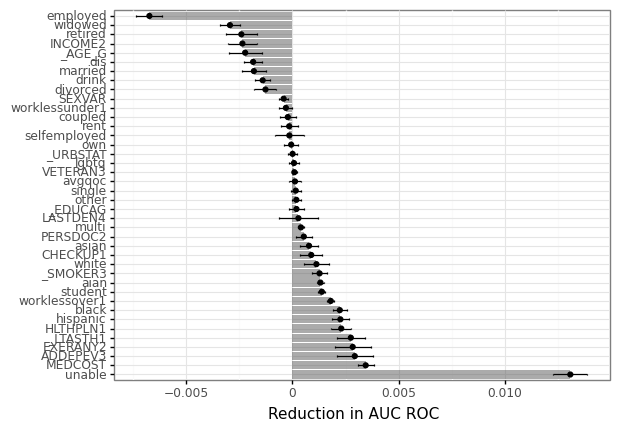

<ggplot: (126985187856)>

In [73]:
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=5)



# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)




# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)